## Existing Solutions

### USGS Stream Stats

USGS Stream Stats used to provide a [web service](https://streamstatsags.cr.usgs.gov/streamstatsservices/#/) to calculate this sort of thing, but apparently the old system was outdated and had to be taken down (security risk due to an old OS). The service has not been reimplemented. When you go there now, you get this:

<img src="images/StreamStatsFail.png" width="500px" />

### USGS Streamer

[Streamer](https://txpub.usgs.gov/DSS/streamer/web/) does pretty much exactly what I want to do, but as far as I can tell, it only does it through a web-mapping interface. In order to use it for what we want, someone would have to navigate to each location we're interested in, click on it, and manually record the report. That's not a viable workflow for the number of locations we're dealing with, so that's out.

...although, there is a JavaScript API. This [interactive demo](https://txpub.usgs.gov/DSS/streamer/api/3.14/web/index.html#tab4?top) suggests that it might be possible to develop a scripted solution through this API, but I'm having a hard time imagining exactly how I'd do it.

### Marine Map Spacing

I did [something](https://github.com/underbluewaters/marinemap/tree/c001e16615caa2178c65ca0684e1b6fd56d3f93d/lingcod/spacing) vaguely similar a long time ago. I think it relies a bit on PostGIS. I'm not sure how much I'll actually refer to that code, but I want to keep track of the link in case I need it.

### Road Network Example

I found [this iPython notebook](http://ipython-books.github.io/featured-03/) and I think it could be useful.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# River Distance Development

I'm trying to develop a scripted method for calculating river distance to the ocean for arbitrary points in Alaska. For a given point location in Alaska, I want to be able to find the nearest point along a waterway and the river distance to the ocean. I intend to do this by converting a river shapefile into a directed network graph, finding the shortest downstream distance to an ocean node, and calculating the distance of that path. The first thing I need to do that is a river shapefile. At first I thought I'd use the Anadromous Waters Catalog shapefile. On closer inspection, I found that many of the lines do not intersect so that shapefile would require extensive manual preparation to be of use. After a bit of searching, I found the [USGS NHD](https://nhd.usgs.gov/index.html) which seems to be ideal for this purpose. The only downside is that the NHD is that it is more detailed than required for our purposes and that its large size may make it difficult to work with. So, I will work with a subset of the NHD to begin with. Once the work flow is sorted out, I may be able to move the processing onto Aurora.

## Subsetting

The NHD features have attributes that contain the HUC codes, so I'll subset the NHD flowlines and nodes to the HUC at the mouth of the Kuskokwim river.

<img src="images/HUCareaKusko.png" width="700px"/>


In [3]:
import geopandas as gpd

In [4]:
gdb_fp = '/Users/jkibele/Documents/SASAP/gis/data_USGS/NHDH_AK.gdb'

Check the layer names with `ogrinfo`.

In [5]:
!ogrinfo $gdb_fp

Had to open data source read-only.
INFO: Open of `/Users/jkibele/Documents/SASAP/gis/data_USGS/NHDH_AK.gdb'
      using driver `OpenFileGDB' successful.
1: ExternalCrosswalk (None)
2: NHDFCode (None)
3: NHDFeatureToMetadata (None)
4: NHDFlow (None)
5: NHDFlowlineVAA (None)
6: NHDMetadata (None)
7: NHDProcessingParameters (None)
8: NHDReachCodeMaintenance (None)
9: NHDReachCrossReference (None)
10: NHDSourceCitation (None)
11: NHDStatus (None)
12: NHDVerticalRelationship (None)
13: NHDPoint (Point)
14: NHDFlowline (Multi Line String)
15: NHDLine (Multi Line String)
16: NHDArea (Multi Polygon)
17: NHDWaterbody (Multi Polygon)
18: NHDAreaEventFC (Multi Polygon)
19: NHDLineEventFC (Multi Line String)
20: NHDPointEventFC (Point)
21: WBDLine (Multi Line String)
22: NonContributingDrainageArea (Multi Polygon)
23: NWISBoundary (Multi Line String)
24: NWISDrainageArea (Multi Polygon)
25: WBDHU14 (Multi Polygon)
26: WBDHU8 (Multi Polygon)
27: WBDHU2 (Multi Polygon)
28: WBDHU4 (Multi Polygon)
29:

### Subset the Flowlines First

In [6]:
flowlines = gpd.read_file(gdb_fp, layer="NHDFlowline")

KeyboardInterrupt: 

Turns out there's one record with a `Null` ReachCode. I'll drop that.

In [ ]:
flowlines.dropna(subset=['ReachCode'], inplace=True)

In [ ]:
len(flowlines)

In [ ]:
kusko_huc = '19030502'
kusko_flowlines = flowlines[flowlines.ReachCode.apply(lambda s: s.startswith(kusko_huc))]

In [ ]:
len(kusko_flowlines)

Convert to Alaska Albers projection and save these lines to a shapefile.

In [ ]:
kusko_flowlines.to_crs(epsg=3338).to_file('data/kusko_flowlines.shp')

### Now Subset the Nodes

**Note:** I don't think I needed to do this. The nodes are implied by the lines and `NetworkX` seems to figure them out okay. 

The nodes don't have attributes with HUC codes. I'll need to select by location, so I'll need to have the shape for the HUC.

In [40]:
huc_fp = 'data/HUCs_3338.shp'
huc = gpd.read_file(huc_fp)

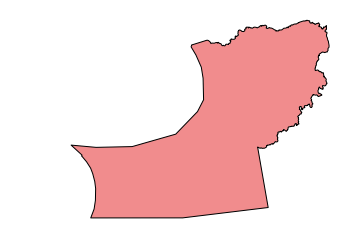

In [53]:
huc.geometry.plot()
blah = plt.axis('off')

In [39]:
nodes = gpd.read_file(gdb_fp, layer="HYDRO_NET_Junctions")

In [68]:
nodes.to_crs(epsg=3338, inplace=True)

In [70]:
type(huc.geometry[0])

shapely.geometry.polygon.Polygon

Find the nodes within the desired hydrological unit.

In [71]:
ind = nodes.within(huc.geometry[0])

In [72]:
nodes[ind].to_file('data/kusko_nodes.shp')

## Build a Network Graph

This will rely pretty heavily on [this example](http://ipython-books.github.io/featured-03/).

In [3]:
import networkx as nx
# for geocalc
from math import radians, sqrt, sin, cos, atan2
import json
from shapely.geometry import LineString

In [4]:
%%time
flowgraph = nx.read_shp('data/kusko_flowlines.shp')

# I'm currently using an even smaller subset in the interest 
# of ease of development.
# flowgraph = nx.read_shp('data/kusko_small.shp')

CPU times: user 27 s, sys: 917 ms, total: 27.9 s
Wall time: 27.7 s


Set up a test start and end point. I got these coordinates from inspecting points in QGIS, but the projection might be different.

In [5]:
pos0 = (-320315, 1284942)
pos1 = (-463112, 1167822)

# These ones work with the extra small shapefile
# pos0 = (-424694, 1227956)
# pos1 = (-420962, 1223502)

I don't want to require users to enter the exact coordinates of a node, so we'll have to be able to find the nearest node for a given position.

In [6]:
def closest_graph_node(pos, g):
    """
    Return the closest node to the given (x,y) position.
    
    Parameters
    ----------
      pos : tuple or list
        Coordinates as (x, y), i.e., (lon, lat) not (lat, lon)
            
      g : networkx.Graph or DiGraph
        
    Returns
    -------
      tuple
        (x, y) coordinates of closest node.
    """
    nodes = np.array(g.nodes())
    node_pos = np.argmin(np.sum((nodes - pos)**2, axis=1))
    return tuple(nodes[node_pos])

### Calculate Edge Distances

In order to weight our shortest path calculations in terms of distance rather than just number of nodes, we need to calculate the along river distance for each edge. [The example](http://ipython-books.github.io/featured-03/) implements a great-circle calculation to do this. Since I'm already planning to use [Shapely](https://github.com/Toblerity/Shapely), I'll just use that to calculate distances too.

In [65]:
def get_path(n0, n1, sg=flowgraph):
    """
    If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the river linking
    these two nodes.
    """
    return np.array(json.loads(sg[n0][n1]['Json'])['coordinates'])

In [61]:
def edge_distance(ed, sg=flowgraph):
    """
    Calculate edge distance by finding all vertices between nodes,
    creating a linestring, and return its distance.
    
    Parameters
    ----------
      ed : tuple or array-like
        The coordinates of the nodes defining the edge. (node0, node1)
        a.k.a. ((x0,y0),(x1,y1)). These must be the exact coords of
        the nodes.
      sg : NetworkX Graph or DiGraph object
        The Graph
        
    Returns
    -------
      length : float
        The edge length in units that are dependent on the projection.
    """
    pth = get_path(*ed, sg=sg)
    return LineString(pth).length

In [62]:
def weight_edges(sg):
    """
    Calculate distance for each edge in a graph and return a copy
    of the graph with `distance` assigned to each edge.
    """
    for ed in sg.edges_iter():
        sg[ed[0]][ed[1]]['distance'] = edge_distance(ed)
    return sg

On closer inspection, I've found that this step isn't really necessary. The NHD shapefile already has a field called `LengthKM`. I can use this to weight the calculations. The only difference between that field and my calculation appears to be the units. My calculations come back in meters (with epsg: 3338, Alaska Albers). Still, the code could be useful later, so it stays.

In [10]:
%%time
flowgraph = weight_edges(flowgraph)

CPU times: user 18.5 s, sys: 46.9 ms, total: 18.5 s
Wall time: 18.5 s


In [11]:
def get_full_path(short_path):
    """
    This will take a path consisting of just nodes, and return the
    full path that contains all the vertices between nodes as well.
    """
    pnts = []
    for i, pnt in enumerate(short_path[:-1]):
        p = get_path(pnt, short_path[i+1])
        pnts.append(p)
    return np.vstack(pnts)

In [12]:
def shortest_full_path(pos0, pos1, sg=flowgraph, weights='LengthKM'):
    """
    Find the shortest full path between 2 positions. This will find 
    the nodes closest to the given positions, the nodes between those 
    nodes for the shortest path, and fill in all the available 
    vertices in the linestring.
    
    Parameters
    ----------
      pos0 : tuple or array-like
        x,y (lon,lat) coordinates for the start point
      pos1 : tuple or array-like
        x,y (lon,lat) coordinates for the end point
      sg : NetworkX Graph or DiGraph object
        The Graph
        
    Returns
    -------
      shapely.geometry.linestring.LineString
        A geometry representing the shortest full path.
    """
    # find the nodes closest to given (x,y) positions
    n0 = closest_graph_node(pos0, sg)
    n1 = closest_graph_node(pos1, sg)
    # find the nodes that define the shortest path between nodes
    pth = nx.shortest_path(sg, n0, n1, weight=weights)
    # fill in the missing vertices
    pth = get_full_path(pth)
    # convert to linestring and return
    return LineString(pth)

In [12]:
closest_graph_node(pos0, flowgraph)

(-320314.74329590303, 1284941.7241701384)

This calculates the shortest path through the graph from one node to another.

In [13]:
short_path = nx.shortest_path(flowgraph, closest_graph_node(pos0, flowgraph), 
                 closest_graph_node(pos1, flowgraph), weight='LengthKM')

This is only the nodes. There are other vertices between nodes.

Length = 249.55 km

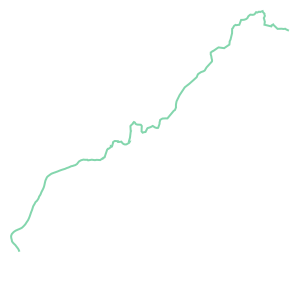

In [14]:
shrt_pth = LineString(short_path)
print "Length = {:.2f} km".format(shrt_pth.length*10**-3),
shrt_pth

Here's the full path:

Length = 275.19 km

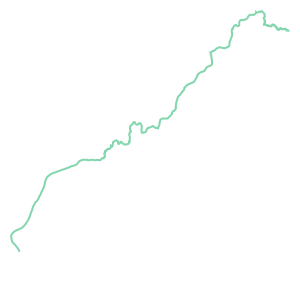

In [15]:
full_pth = shortest_full_path(pos0, pos1, flowgraph)
print "Length = {:.2f} km".format(full_pth.length * 10**-3),
full_pth

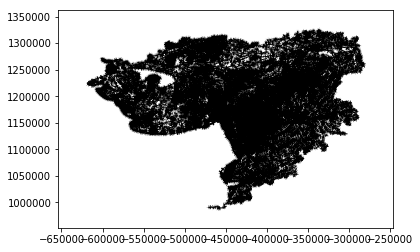

In [37]:
nx.draw_networkx_edges(flowgraph, dict(zip(flowgraph.nodes(), flowgraph.nodes())))

## Identifying Ocean Nodes

In order to find the shortest path to the ocean for given spot on a river, I'll need to identify which nodes constitute an ocean end point. It turns out that this may be simpler than I thought it would be. The NHD has an attribute for this purpose. It's the `FCode` value $56600$ described [here](https://nhd.usgs.gov/userGuide/Robohelpfiles/NHD_User_Guide/Feature_Catalog/Hydrography_Dataset/Complete_FCode_List.htm) and, in a bit more detail, [here](https://nhd.usgs.gov/FeatureDirectory.pdf).

In [16]:
def is_coastal(node, sg=flowgraph, fcode=56600):
    """
    Return `True` if the given node is coastal. We call a node coastal
    if it is connected to an edge that has an `FCode` of 56600. According
    to the NHDFlowline feature type list (nhd.usgs.gov), that `FCode`
    means "coastline".
    """
    node = tuple(node)
    # get the edges with FCodes
    edges = sg.edges(node, data='FCode')
    # get a list of FCodes from edges connected to the node
    fc_list = [fc for e1, e2, fc in edges]
    if fcode in fc_list:
        result = True
    else:
        result = False
    return result

In [17]:
nd = flowgraph.nodes()[0]

In [18]:
# nx.get_edge_attributes(flowgraph, 'FCode').values()

This will speed things up. As a first step given a start node, I can get all the downstream nodes.

In [19]:
def reachable_nodes(start_node, sg=flowgraph):
    """
    Return an array of reachable downstream nodes from `start_node` in
    the directed graph `sg`.
    """
    reach_set = nx.descendants(sg, start_node)
    return list(reach_set)

In [19]:
start_node = closest_graph_node(pos0, flowgraph)
re_nodes = reachable_nodes(start_node)
len(re_nodes)

2318

In [20]:
def reachable_coast_nodes(start_node, sg=flowgraph, fcode=56600):
    """
    Given a start_node, return only the reachable nodes that are coastal.
    """
    rn = np.array(reachable_nodes(start_node, sg=sg))
    return rn[np.apply_along_axis(is_coastal, 1, rn)].tolist()

In [21]:
def has_coast_node(node_list, sg=flowgraph, fcode=56600):
    """
    Given a list of nodes, return `True` if at least one node is
    coastal. Otherwise, return `False`.
    """
    return np.apply_along_axis(is_coastal, 1, np.array(node_list)).any()

In [22]:
has_coast_node(re_nodes)

NameError: name 're_nodes' is not defined

In [ ]:
def prune_network(sg=flowgraph, fcode=56600, verbose=False):
    """
    Remove subgraphs of the network that do not connect to the coastline.
    """
    coast_n = 0
    noncoast_n = 0
    g_list = []
    cps = nx.weakly_connected_component_subgraphs(sg)
    for cp in cps:
        if has_coast_node(cp.nodes(), sg=sg, fcode=fcode):
            g_list.append(cp)
            coast_n += 1
        else:
            noncoast_n += 1
    if verbose:
        print "{} graphs with coastal nodes, {} without.".format(coast_n, noncoast_n)
    return nx.union_all(g_list)

In [206]:
%%time
pruned = prune_network(flowgraph, verbose=True)

47 graphs with coastal nodes, 4898 without.
CPU times: user 3min 8s, sys: 4.84 s, total: 3min 13s
Wall time: 3min 13s


In [201]:
# gunion2 = nx.union_all(g_list)
# nx.write_shp(gunion2, "nx_out/")

In [24]:
len(flowgraph)

197027

### Find Candidates for Closest Coastal Node

1. Get subgraph of descendants from start node: `subg`
2. Identify coastal nodes in `subg`
3. Remove coastal nodes with only coastal ancestors from `subg`

In [2]:
from river_graph import RiverGraph
from graph_prep import GraphBuilder

In [3]:
import networkx as nx

In [4]:
%%time
# gb = GraphBuilder('data/kusko_pruned.pkl')
gb = GraphBuilder('data/kusko_flowlines.shp')
rg = gb.graph

CPU times: user 31.6 s, sys: 1.3 s, total: 32.9 s
Wall time: 32.7 s


In [5]:
%%time
pos0 = (-320315, 1284942)
pos1 = (-463112, 1167822)
start_node = rg.closest_node(pos0)
subg = rg.reachable_subgraph(start_node)

CPU times: user 209 ms, sys: 5.86 ms, total: 214 ms
Wall time: 213 ms


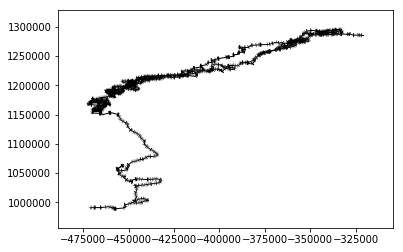

In [6]:
# nx.draw_networkx_edges(subg, dict(zip(subg.nodes(), subg.nodes())))
subg.plot()

In [22]:
len(rg.nodes()), len(rg.reachable_nodes(start_node))

(197027, 2318)

In [23]:
cstlnds = subg.reachable_coast_nodes(start_node)

In [25]:
ind = np.apply_along_axis(subg.only_coastal_predecessors, 1, np.array(cstlnds))
np.array(cstlnds)[~ind]

array([[ -464903.30776724,  1149360.96955807]])

In [26]:
tcns = subg.terminal_coastal_nodes(start_node).tolist()

In [31]:
for tcn in tcns:
    print subg.shortest_full_path(start_node, tcn).length

294145.104359


In [49]:
blah = [b for b in reversed(range(2,10))]
blah

[9, 8, 7, 6, 5, 4, 3, 2]

In [53]:
foo = dict(zip(blah, range(len(blah))))
foo

{2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1, 9: 0}

In [58]:
min(foo.keys())

2

In [12]:
start_node in rg.nodes()

True

### Find Shortest Path to Coast

Calculate shortest path distance to each candidate node and keep the shortest.

CPU times: user 495 ms, sys: 17.8 ms, total: 512 ms
Wall time: 501 ms


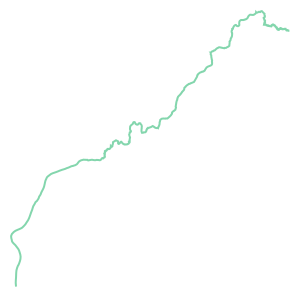

In [6]:
%%time
rg.shortest_path_to_coast(start_node)

CPU times: user 119 ms, sys: 15.8 ms, total: 134 ms
Wall time: 123 ms


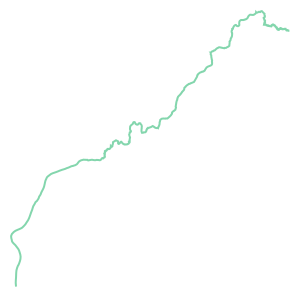

In [7]:
%%time
subg.shortest_path_to_coast(start_node)